In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
import cufflinks as cf
import binance

# Importing datas from Binance using the library "binance"

client = binance.Client()
data = client.get_historical_klines('ETHBUSD', client.KLINE_INTERVAL_1DAY, '14-Dec-2019', '2-Feb-2023')
for i in range(0, len(data)):
    for j in range(0,11):
        data[i][j] = float(data[i][j])
for line in data:
    del line[2:4]
    del line[2:]

pd.options.display.max_rows = 999999
data = pd.DataFrame(data,columns = ['Date','Close'])
data['Date'] = pd.to_datetime(data['Date'], unit = 'ms',utc = True).map(lambda x:x.tz_convert('Europe/Rome'))
data.set_index('Date', inplace = True)

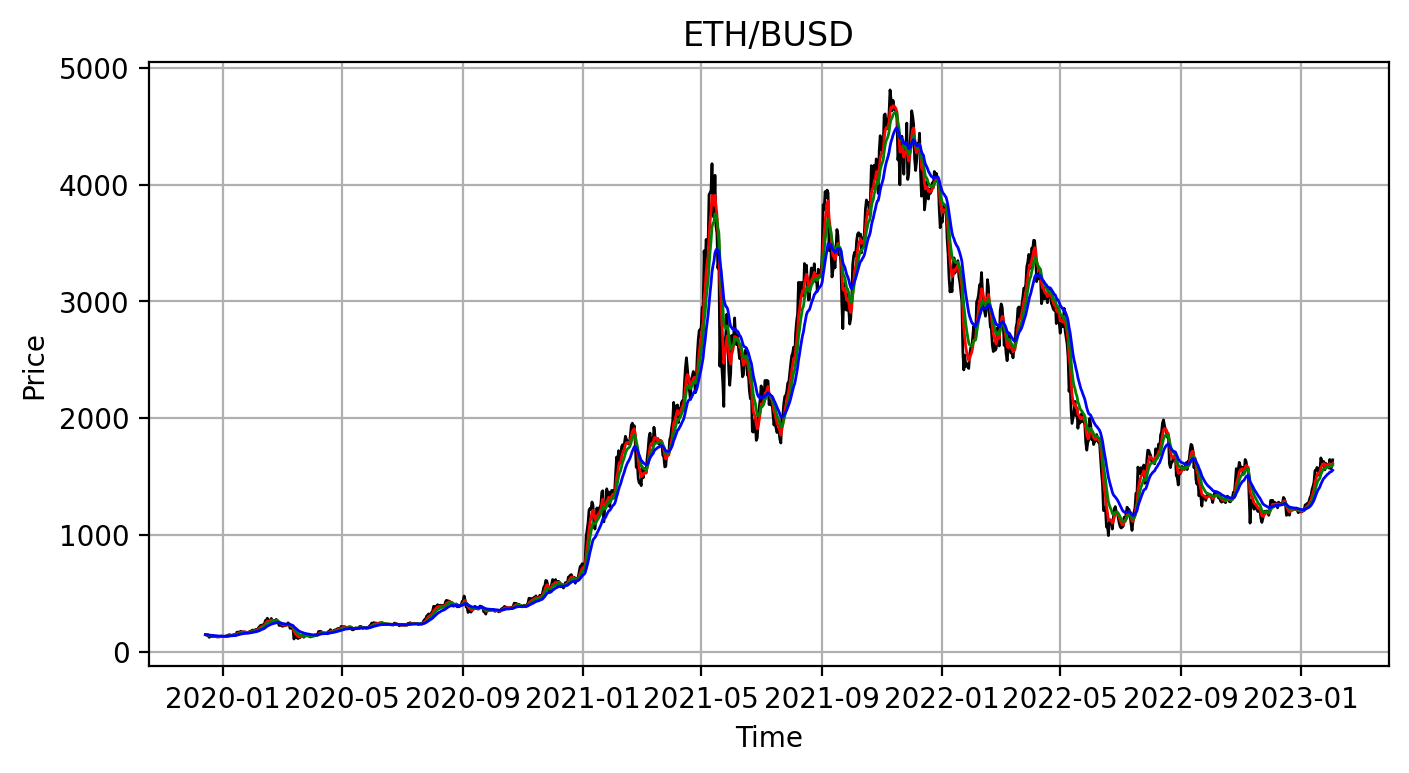

In [2]:
# Backtesting a stretgy that uses 3 esponential moving averages

data["EMA5"] = data.Close.ewm(span = 5, adjust = False).mean()
data["EMA10"] = data.Close.ewm(span = 10, adjust = False).mean()
data["EMA20"] = data.Close.ewm(span = 20, adjust = False).mean()

plt.figure(figsize = (8,4), dpi = 200)
plt.plot(data.Close, color = 'black', linewidth = 1.0)
plt.plot(data.EMA5, color = 'red', linewidth = 1.0)
plt.plot(data.EMA10, color = 'green', linewidth = 1.0)
plt.plot(data.EMA20, color = 'blue', linewidth = 1.0)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("ETH/BUSD")
plt.grid(True)
plt.show();

In [3]:
data["DeltaPerc"]= data.Close.pct_change() # variazione percentuale tra la close n e la close n-1

data["Position"] = np.where(((data.EMA5 > data.EMA10) & (data.EMA5 > data.EMA20)), 1, 0) # 1 quando la posizione è aperta / 0 quando è chiusa

data.Position = data.Position.shift(1) # shifto tutto di 1 altrimenti mi prevede il futuro

data["StrategyPerc"] = (data.DeltaPerc * data.Position) # Deltaperc quando Position = 1 / 0 altrimenti

data["Strategy_Equity"] = (data.StrategyPerc + 1).cumprod() * 100

data.dropna(inplace = True)

In [4]:
data.tail(10)

,Close,EMA5,EMA10,EMA20,DeltaPerc,Position,StrategyPerc,Strategy_Equity
Date,,,,,,,,
2023-01-24 01:00:00+01:00,1626.54,1611.595024,1567.333873,1484.439190,-0.000897,1.0,-0.000897,2519.016050
2023-01-25 01:00:00+01:00,1556.21,1593.133350,1565.311351,1491.274505,-0.043239,1.0,-0.043239,2410.096258
2023-01-26 01:00:00+01:00,1612.16,1599.475566,1573.829287,1502.787409,0.035953,1.0,0.035953,2496.745801
2023-01-27 01:00:00+01:00,1601.22,1600.057044,1578.809417,1512.161942,-0.006786,1.0,-0.006786,2479.803067
2023-01-28 01:00:00+01:00,1597.84,1599.318030,1582.269523,1520.321757,-0.002111,1.0,-0.002111,2474.568474
2023-01-29 01:00:00+01:00,1572.30,1590.312020,1580.456882,1525.272066,-0.015984,1.0,-0.015984,2435.014777
2023-01-30 01:00:00+01:00,1645.01,1608.544680,1592.193813,1536.675678,0.046244,1.0,0.046244,2547.620466
2023-01-31 01:00:00+01:00,1566.36,1594.483120,1587.496756,1539.502757,-0.047811,1.0,-0.047811,2425.815523
2023-02-01 01:00:00+01:00,1585.32,1591.428747,1587.100982,1543.866304,0.012104,1.0,0.012104,2455.178800


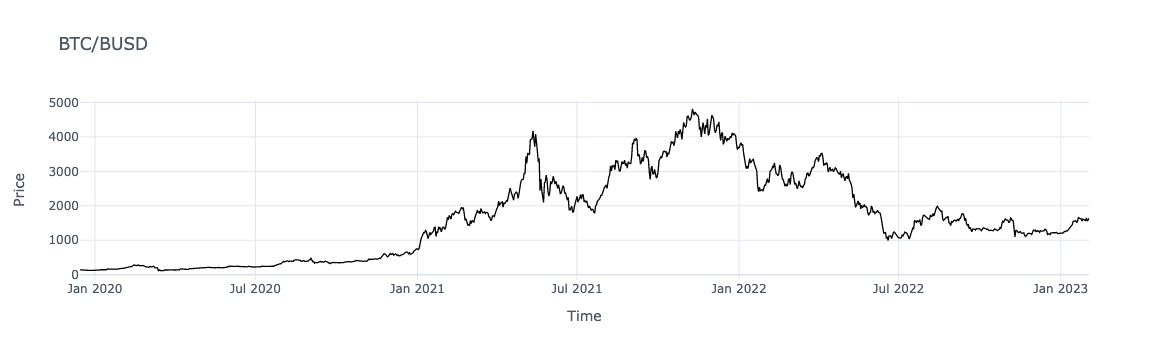

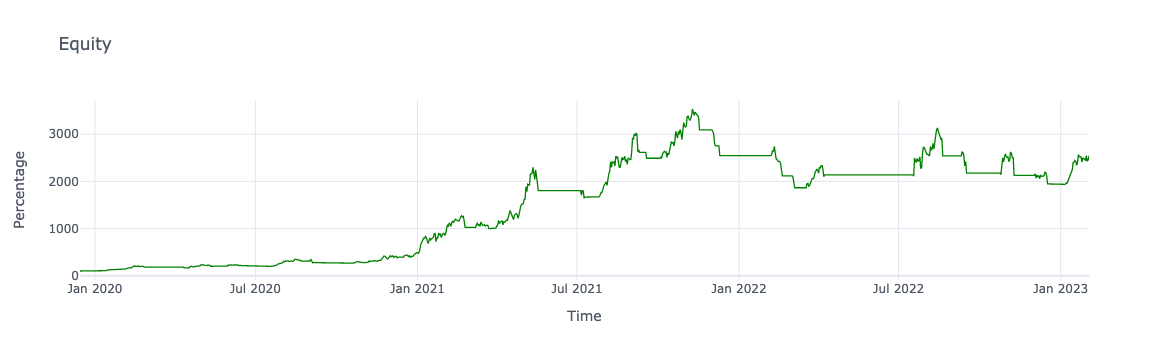

In [5]:
cf.go_offline() # will make cufflinks offline
cf.set_config_file(offline = False, world_readable = True)
data.Close.iplot(kind = "line", color = "black", theme = "white", title = "BTC/BUSD", xTitle = "Time", yTitle = "Price")
data.Strategy_Equity.iplot(kind = "line", color = "green", theme = "white", title = "Equity", xTitle = "Time", yTitle = "Percentage")